# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory_varybatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix


cpu


'Jul27-2241'

In [4]:
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
    'contrastive',
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", 
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
distribution = 'normal'
batch_distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [6]:
"""
Single‑trajectory benchmark in which every *pair* of batches has the same
batch‑effect type at two different strengths (“low” / “high”).  This version
uses **option 2**: EFFECT_SPEC is a list of (effect_type, spec‑dict) tuples,
so you can repeat the same effect type with different parameterisations
(e.g. different noise distributions).
"""

import numpy as np
import anndata as ad
from concord.simulation import (
    Simulation,
    SimConfig, TrajectoryConfig, BatchConfig
)

# ───────────────────────── USER‑TUNABLES ──────────────────────────
TOTAL_CELLS   = 4_000        # overall cells (evenly split by default)
TOTAL_GENES   = 2_000
SEED_STATE    = 42
SEED_BATCH    = 4_242

# Two‑element “level” lists ⇒ [low, high]
EFFECT_SPEC = [
    ("variance_inflation",
        dict(level=[1, 4])),                             # multiplicative
    ("batch_specific_distribution",
        dict(level=[1, 5], distribution="normal")),
    ("batch_specific_distribution",
        dict(level=[1, 5], distribution="negative_binomial")),
    ("uniform_dropout",
        dict(level=[0.1, 0.4])),
    # ("value_dependent_dropout",
    #     dict(level=[0.01, 0.05])),
    ("downsampling",
        dict(level=[0.2, 0.8])),
    ("scaling_factor",
        dict(level=[0.5, 2.0])),
    ("batch_specific_expression",
        dict(level=[5, 10], distribution="normal", feature_frac=0.10)),
    ("batch_specific_features",
        dict(level=[5, 10], distribution="normal", feature_frac=0.10)),
]

traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 6.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.2,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)


# ─────────────── Build per‑batch parameter lists ──────────────────
n_effects  = len(EFFECT_SPEC)
rng        = np.random.default_rng(SEED_BATCH)

types, levels, dists, disps, f_fracs, cell_props, labels = (
    [], [], [], [], [], [], []
)

for eff, spec in EFFECT_SPEC:
    # two batches per effect type
    types.extend([eff, eff])

    # levels and other params
    lvl_low, lvl_high = spec.get("level", [None, None])
    levels.extend([lvl_low, lvl_high])

    dist = spec.get("distribution", "normal")
    dists.extend([dist, dist])

    disp = spec.get("dispersion", 2.0)
    disps.extend([disp, disp])

    ff = spec.get("feature_frac", 0.0)
    f_fracs.extend([ff, ff])

    # equal cell proportion by default
    cell_props.extend([1 / (2 * n_effects)] * 2)

    # human‑readable batch labels
    base = eff if eff != "batch_specific_distribution" else f"{eff}_{dist}"
    labels.extend([f"{base}_low", f"{base}_high"])

# ─────────────── Assemble BatchConfig ─────────────────────────────
batch_cfg = BatchConfig(
    n_batches       = len(types),
    effect_type     = types,
    distribution    = dists,
    level           = levels,
    dispersion      = disps,
    feature_frac    = f_fracs,
    cell_proportion = cell_props,
)

# ─────────────── Assemble SimConfig & run ────────────────────────
sim_cfg = SimConfig(
    n_cells = TOTAL_CELLS,
    n_genes = TOTAL_GENES,
    seed    = SEED_STATE,
    non_neg = True,
    to_int  = True,
)

sim = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()

# map descriptive labels to batches (order preserved)
adata.obs["batch_label"] = adata.obs["batch"].map(
    dict(zip(adata.obs["batch"].unique(), labels))
)
adata.obs['batch_type'] = adata.obs["batch"].map(
    dict(zip(adata.obs["batch"].unique(), types))
)

print(adata)


AnnData object with n_obs × n_vars = 4000 × 2400
    obs: 'time', 'batch', 'batch_id', 'batch_label', 'batch_type'
    layers: 'no_noise', 'wt_noise', 'counts'


In [7]:
import pandas as pd
pd.crosstab(adata.obs["batch_label"], adata.obs["batch_type"])

batch_type,batch_specific_distribution,batch_specific_expression,batch_specific_features,downsampling,scaling_factor,uniform_dropout,variance_inflation
batch_label,,,,,,,
batch_specific_distribution_negative_binomial_high,250,0,0,0,0,0,0
batch_specific_distribution_negative_binomial_low,250,0,0,0,0,0,0
batch_specific_distribution_normal_high,250,0,0,0,0,0,0
batch_specific_distribution_normal_low,250,0,0,0,0,0,0
batch_specific_expression_high,0,250,0,0,0,0,0
batch_specific_expression_low,0,250,0,0,0,0,0
batch_specific_features_high,0,0,250,0,0,0,0
batch_specific_features_low,0,0,250,0,0,0,0
downsampling_high,0,0,0,250,0,0,0


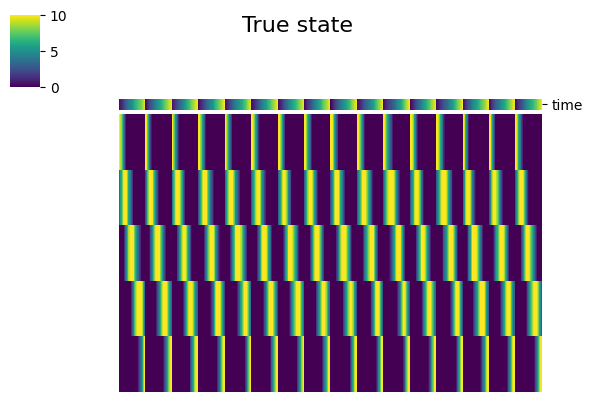

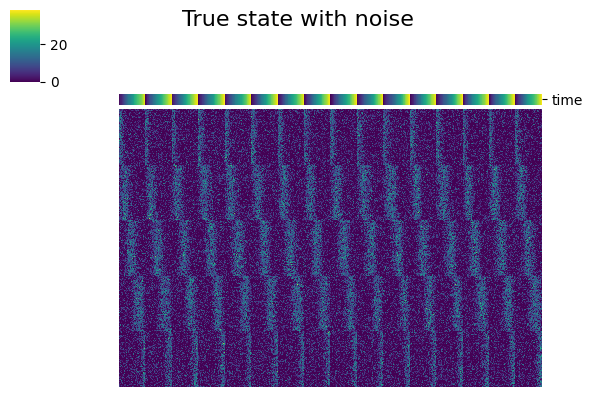

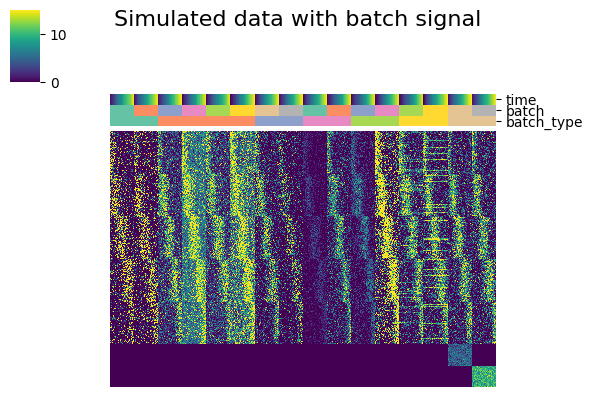

In [8]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', vmax=15, obs_keys=[state_key, batch_key, 'batch_type'], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

## Integration pipeline

In [9]:
run_methods = concord_methods + other_methods
latent_dim = 30

In [12]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='no_noise_PCA', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='wt_noise_PCA', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata.obsm['no_noise_PCA'] = adata_state.obsm['no_noise_PCA']
adata.obsm['wt_noise'] = adata.obsm['wt_noise_PCA'] = adata_state.obsm['wt_noise_PCA']

concord - INFO - PCA performed on source data with 30 components
concord - INFO - PCA embedding stored in adata.obsm['no_noise_PCA']
concord - INFO - PCA performed on source data with 30 components
concord - INFO - PCA embedding stored in adata.obsm['wt_noise_PCA']


In [13]:
concord_kwargs = {
    'batch_size': 32,
    'n_epochs': 20,
    'load_data_into_memory': True,
    'verbose': False,
}
profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=run_methods,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=seed,                              # Random seed for reproducibility
    compute_umap=False,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
    concord_kwargs=concord_kwargs,          # Additional kwargs for CONCORD
)


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_knn: 10.96s | 45.22 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_hcl: 8.14s | 1.03 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skippin

contrastive: 8.69s | 0.17 MB RAM | 0.00 MB VRAM
Running PCA for 'unintegrated' embedding …


Found 2400 genes among all datasets


scanorama: 0.78s | 333.06 MB RAM | 0.00 MB VRAM


[[0.    0.004 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    

100%|██████████| 30/30 [02:34<00:00,  5.16s/it]
liger: 158.26s | 788.09 MB RAM | 0.00 MB VRAM


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


harmony: 4.19s | 1.44 MB RAM | 0.00 MB VRAM
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
scvi: 194.62s | 96.91 MB RAM | 0.00 MB VRAM
✅ All selected methods completed.


In [17]:
for basis in combined_keys:
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=seed)

Running UMAP for no_noise
Running UMAP for wt_noise
Running UMAP for concord_hcl
Running UMAP for concord_knn
Running UMAP for contrastive
Running UMAP for unintegrated
Running UMAP for scanorama
Running UMAP for liger
Running UMAP for harmony
Running UMAP for scvi


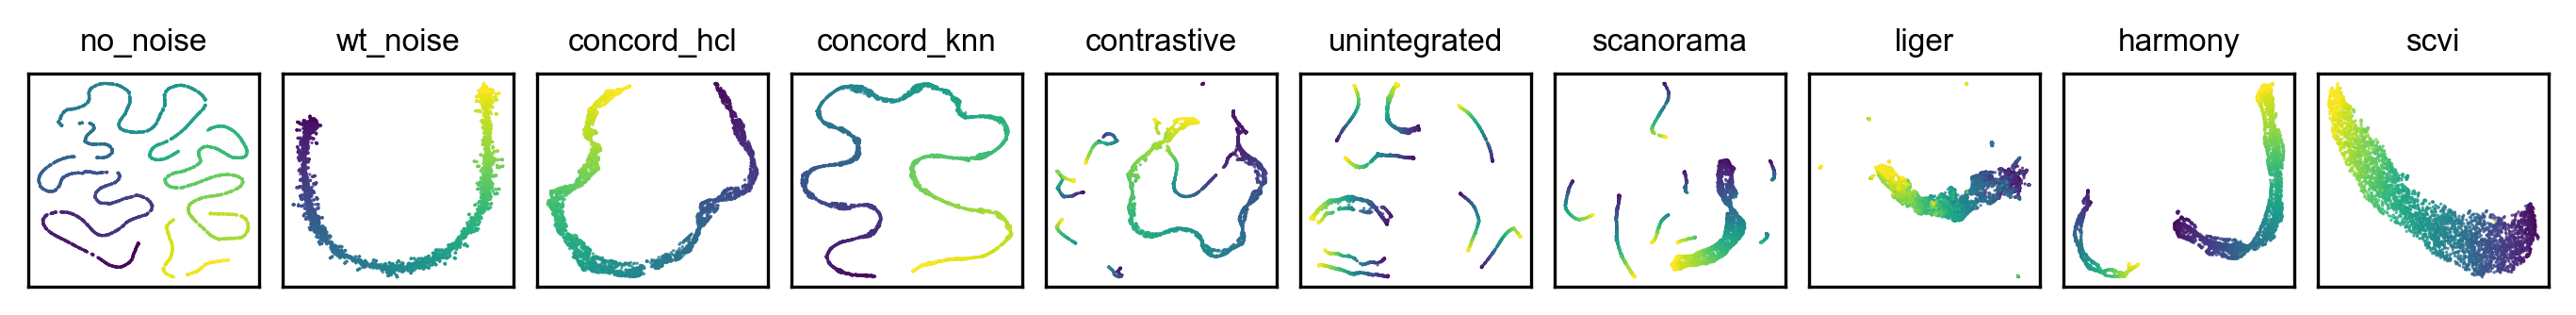

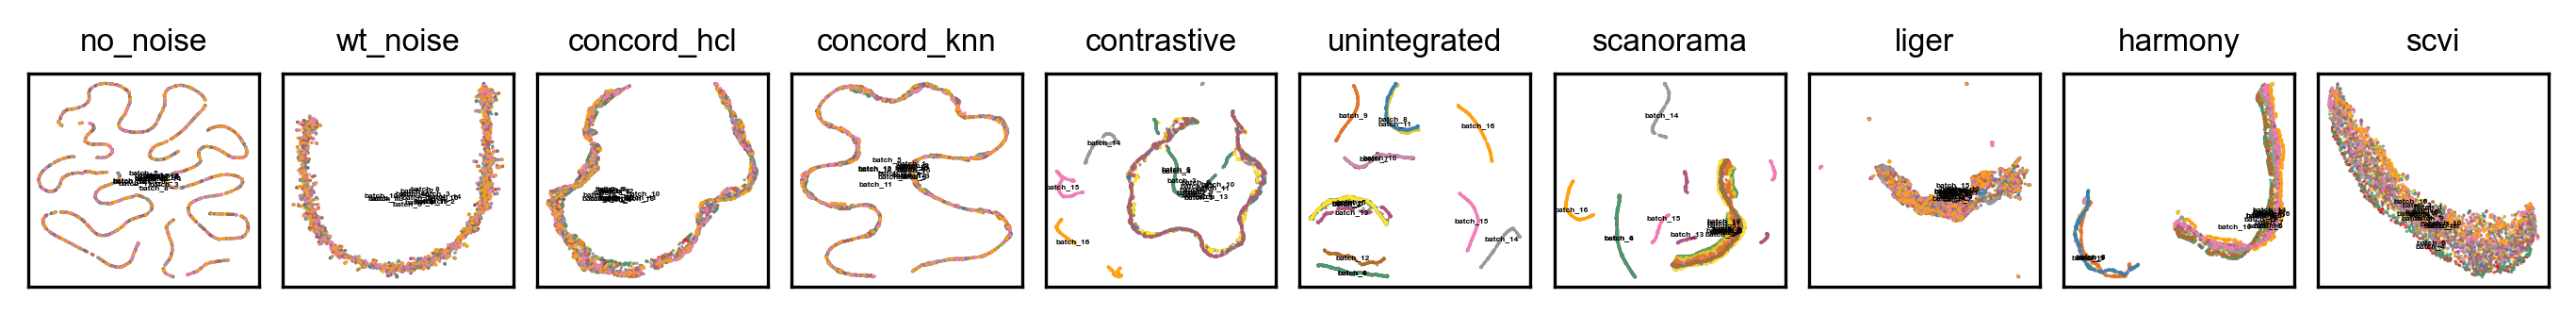

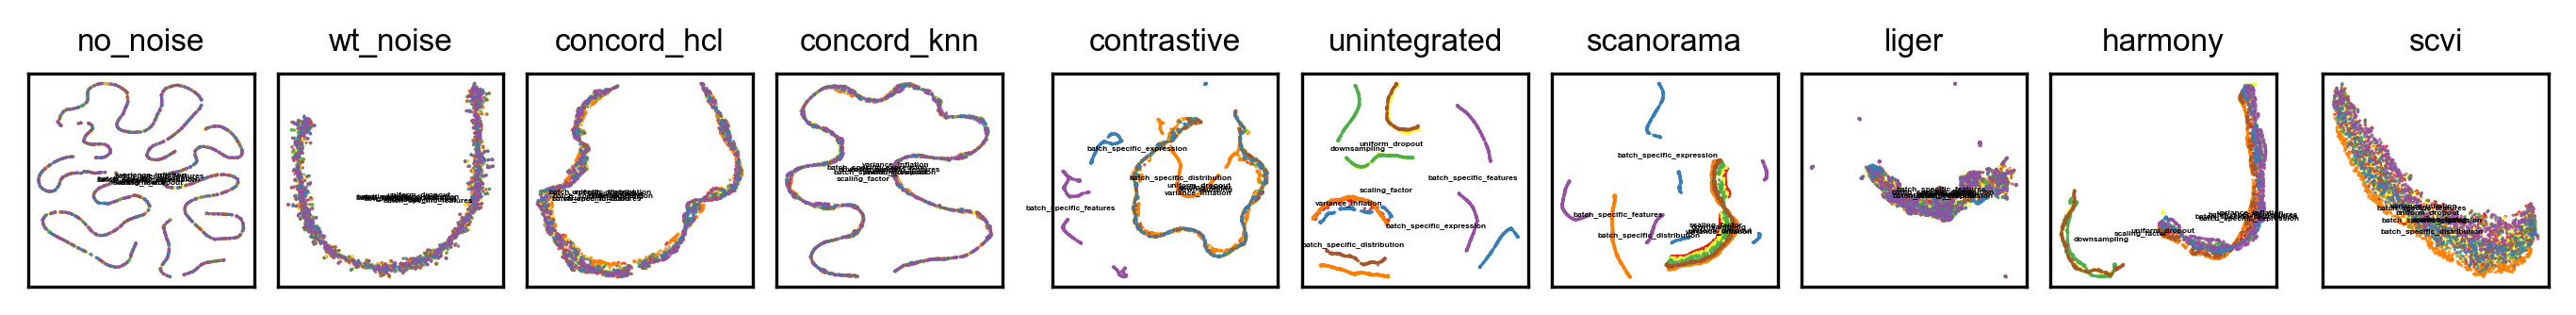

In [18]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in combined_keys if key in adata.obsm.keys()]
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch', 'batch_type']
basis_types = ['UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed+2,
        leiden_key='leiden',
        save_dir=save_dir,
        legend_loc = 'on data',
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )
